# Gamma = 0.7

In [83]:
# import cupy as np
import numpy as np
from time import time
import random
from tqdm import tqdm


# pool = np.cuda.MemoryPool(np.cuda.malloc_managed)
# np.cuda.set_allocator(pool.malloc)

def DivisibleQ(x, b):
    if np.remainder(x, b) == 0:
        return True
    else:
        return False


def hopping_list(Lx, Ly):
    test = []        
    for i in range(Lx*Ly):
        if DivisibleQ(np.floor_divide(i, Lx), 4) == True:
            if np.remainder(i, Lx) == 0:
                test.append((i,i + Lx))
                test.append((i,i + 2*Lx-1))
                if i-Lx>0:
                    test.append((i,i-Lx))        
            else:
                test.append((i,i + Lx-1))
                test.append((i,i + Lx))
                if i-Lx>0:
                    test.append((i,i-Lx))
        if DivisibleQ(np.floor_divide(i, Lx) + 2, 4) == True:
            if np.remainder(i, Lx) == Lx-1:
                test.append((i,i+Lx))
                test.append((i,i+1))
                test.append((i,i-Lx))
            else:
                test.append((i,i+Lx+1))
                test.append((i,i+Lx))
                test.append((i,i-Lx))
    return test


    
def coordinate(j, Lx, Ly):
    x = j % Lx + 1
    ## With this notation the top left site is 0
    y = Ly - (j // Lx + 1) + 1
    if y % 2 == 1 and ((y + 1)/2) % 2 == 1:
        return (x, ((y + 1)/2) * np.sqrt(3)/2)
    if y % 2 == 1 and ((y + 1)/2) % 2 == 0:
        return (x + 1/2, ((y + 1)/2) * np.sqrt(3)/2)
    if y % 2 == 0 and (y/2) % 2 == 0:
        return (x, (y/2) * np.sqrt(3)/2 + 1/(2*np.sqrt(3)))
    if y % 2 == 0 and (y/2) % 2 == 1:
        return (x + 1/2, (y/2) * np.sqrt(3)/2 + 1/(2*np.sqrt(3)))
    
def matlab_round(x):
    if x - int(x) >= 0.5:
        return int(np.ceil(x))
    else:
        return int(x)

def hopping_matrix(Lx, Ly, t):
    # """Hopping matrix  needs t = 1"""
    draft_hopping = np.zeros((Lx*Ly, Lx*Ly))
    for element in hopping_list(Lx, Ly):
        draft_hopping[element] = -t
    return draft_hopping + np.transpose(draft_hopping)


################### INITIAL CONDITIONS ########################
# Revised note: Add random initial condition
# and ferromagnetic initial condition
    
## Half-half and antiferromagnetic
def initial_condition(Lx, Ly, U, gamma):
    lst = []
    for i in range(Lx * Ly):
        yi = Ly - (i // Lx + 1) + 1
        if yi % 2 == 0:
            lst.append(U * (nf/2))
        else:
            lst.append(U * (-nf/2))
            
    if gamma > 1e-3:
        return np.diag(np.random.choice((U * 0.001, -U * 0.001), Lx * Ly))
    else:
        return np.diag(lst)

# ## RANDOM INITIAL CONDITION ##
# def initial_condition(Lx, Ly, t, U, gamma):
# # n_up * (n_down - 1/2)
#     return np.diag(U * (np.random.rand(Lx*Ly) - nf/2))



# ## Ferromagnetic inital condition ##
# def initial_condition(Lx, Ly, t, U, gamma):
# # n_up * (n_down - 1/2)
#     lst = []
#     for i in range(Lx * Ly):
#         lst.append(U * (-nf/2))
#     return np.diag(lst)

###############################################################


def impurity_matrix(Lx, Ly, gamma):
# """Add interaction U and disorder gamma to variable list"""
    draft_impurity = np.zeros(Lx*Ly)
    for impurity_site in random.sample(range(Lx*Ly), matlab_round(Lx*Ly*imp)):
        draft_impurity[impurity_site] = np.random.uniform(-gamma, gamma)
    return np.diag(draft_impurity)
    
def self_consistent_solution(Lx, Ly, t, U, gamma, number_iteration=14):
    impurity_term = impurity_matrix(Lx, Ly, gamma)
    ini_hamil = hopping_matrix(Lx, Ly, t) + impurity_term
    ini_cond = initial_condition(Lx, Ly, U, gamma)
    val_up, vec_up = np.linalg.eigh(ini_hamil + ini_cond)
    val_dn, vec_dn = np.linalg.eigh(ini_hamil - ini_cond)    
    
    def average_n_matrix(vec):
        average_n = 0
        for i in range(int((Lx*Ly+dope)/2)):
            average_n = average_n + abs(vec[:, i])**2
        average_n = U * (average_n - nf/2)
        return np.diag(average_n)
    
    # The HF loop
    hamil_up = ini_hamil + average_n_matrix(vec_dn)
    hamil_dn = ini_hamil + average_n_matrix(vec_up)    
    for i in range(number_iteration):
        print("At iteration: " + str(i))
        val_up, vec_up = np.linalg.eigh(hamil_up)
        val_dn, vec_dn = np.linalg.eigh(hamil_dn)
        hamil_up = ini_hamil + average_n_matrix(vec_dn)
        hamil_dn = ini_hamil + average_n_matrix(vec_up)
    # return np.vstack((np.hstack((hamil_up, np.zeros((Lx*Ly, Lx*Ly)))),np.hstack((np.zeros((Lx*Ly, Lx*Ly)), hamil_dn))))
    return hamil_up, hamil_dn

### Revised note:
### I removed the vstack, hstack to solve full Hamiltonian
### instead I solve H_up and H_dn independently 

def occupation_spin(vector_solution, Lx, Ly):
    HF_sol = np.power(vector_solution[:, 0: (Lx*Ly+dope)//2], 2)
    sz = np.sum(HF_sol, axis=1)
    return np.ndarray.flatten(sz).tolist()




t = 1
#############
U = 10
#############
imp = 0.1
dope = 30

# #### Large parameters
# Lx = 100
# Ly = 64
# nf = 1 + dope/(Lx * Ly)
# gamma = 4

# #### Large parameters
# Lx = 50
# Ly = 32
# nf = 1 + dope/(Lx * Ly)
# gamma = 4


#### Large parameters
Lx = 120
Ly = 8
nf = 1 + dope/(Lx * Ly)
gamma = 1


# NO DISORDER

the_system = self_consistent_solution(Lx, Ly, t, U, 0)
val_up, vec_up = np.linalg.eigh(the_system[0])
val_dn, vec_dn = np.linalg.eigh(the_system[1])


n_up = occupation_spin(vec_up, Lx, Ly)
n_dn = occupation_spin(vec_dn, Lx, Ly)
sz  = 0.5 * (np.array(n_up) - np.array(n_dn))
sz = np.ndarray.flatten(sz).tolist()

sz_clean = sz
n_up_clean = n_up


# DISORDER

the_system = self_consistent_solution(Lx, Ly, t, U, gamma)
val_up, vec_up = np.linalg.eigh(the_system[0])
val_dn, vec_dn = np.linalg.eigh(the_system[1])


n_up = occupation_spin(vec_up, Lx, Ly)
n_dn = occupation_spin(vec_dn, Lx, Ly)
sz  = 0.5 * (np.array(n_up) - np.array(n_dn))
sz = np.ndarray.flatten(sz).tolist()


sz_disorder = sz
n_up_disorder = n_up


At iteration: 0
At iteration: 1
At iteration: 2
At iteration: 3
At iteration: 4
At iteration: 5
At iteration: 6
At iteration: 7
At iteration: 8
At iteration: 9
At iteration: 10
At iteration: 11
At iteration: 12
At iteration: 13
At iteration: 0
At iteration: 1
At iteration: 2
At iteration: 3
At iteration: 4
At iteration: 5
At iteration: 6
At iteration: 7
At iteration: 8
At iteration: 9
At iteration: 10
At iteration: 11
At iteration: 12
At iteration: 13


In [85]:
import numpy as np


delta_n = np.array(n_up_disorder) - np.array(n_up_clean)
# delta_n = sz_disorder

delta_n = np.reshape(delta_n, (Ly, Lx))

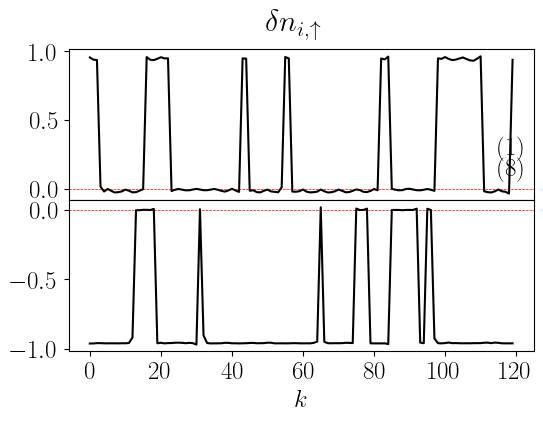

In [86]:
import matplotlib.pyplot as plt

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

fig, (ax1, ax2) = plt.subplots(2, dpi=100, sharex=True)
fig.subplots_adjust(hspace=0)





# fig.suptitle("%2.0f doped electron, $U = %5.1f t, \Gamma = %5.1f t$" % tuple((dope, U, gamma)))
fig.suptitle(r"$\delta n_{i, \uparrow}$", fontsize=22)



#######################
ax1.plot(range(Lx), delta_n[0], color = 'k')
ax2.plot(range(Lx), delta_n[Ly-1], color = 'k')

for ax in [ax1, ax2]:
  # ax.set_ylim(-0.7,0.7)
  # ax.set_yticks([-0.6, 0, 0.6])
  ax.axhline(0, linestyle='--', color = 'r', zorder=1, linewidth=0.5)
  ax.tick_params(axis='both', which='major', labelsize=18)

ax1.text(115, 0.25, '(1)', fontsize=18)
ax2.text(115, 0.25, '(8)', fontsize=18)
ax2.set_xticks(np.arange(0, Lx+1, 20))
ax2.set_xlabel(r"$k$", fontsize=18)

  
plt.show()

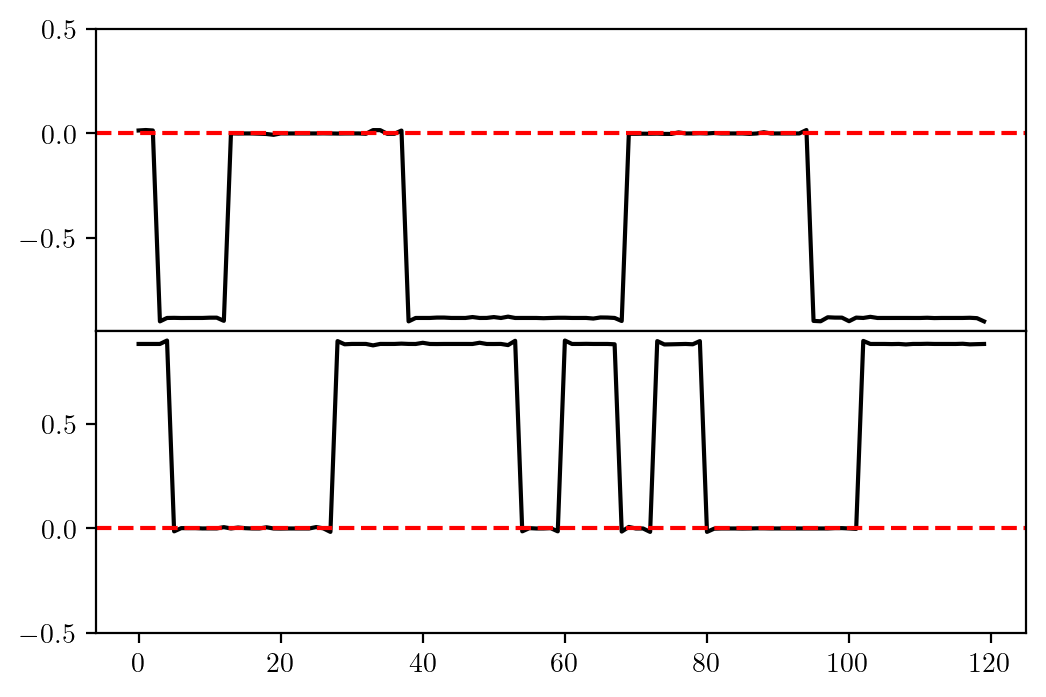

In [14]:
import matplotlib.pyplot as plt

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

fig, (ax1, ax2) = plt.subplots(2, dpi=200, sharex=True)
fig.subplots_adjust(hspace=0)





# fig.suptitle("%2.0f doped electron, $U = %5.1f t, \Gamma = %5.1f t$" % tuple((dope, U, gamma)))


#######################
ax1.plot(range(Lx), delta_n[1], color = 'k')
ax2.plot(range(Lx), delta_n[Ly-2], color = 'k')

for ax in [ax1, ax2]:
    # ax.set_ylim(-0.55,0.55)
    ax.set_yticks([-0.5, 0, 0.5])
    ax.axhline(0, linestyle='--', color = 'r')
    
    

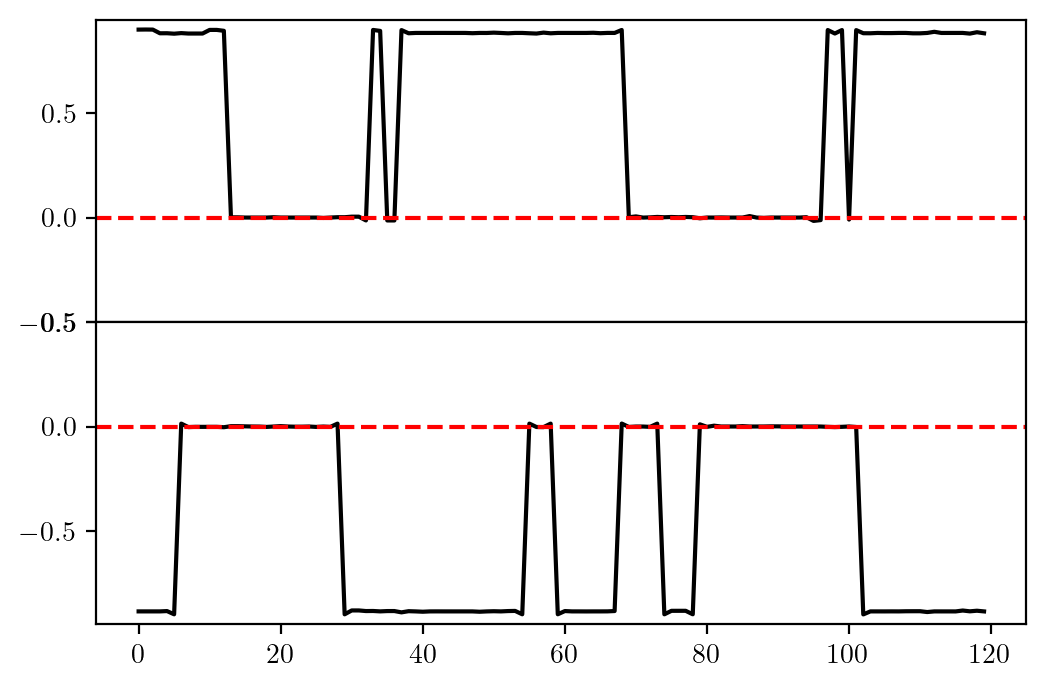

In [15]:
import matplotlib.pyplot as plt

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

fig, (ax1, ax2) = plt.subplots(2, dpi=200, sharex=True)
fig.subplots_adjust(hspace=0)





# fig.suptitle("%2.0f doped electron, $U = %5.1f t, \Gamma = %5.1f t$" % tuple((dope, U, gamma)))


#######################
ax1.plot(range(Lx), delta_n[2], color = 'k')
ax2.plot(range(Lx), delta_n[Ly-3], color = 'k')

for ax in [ax1, ax2]:
    # ax.set_ylim(-0.55,0.55)
    ax.set_yticks([-0.5, 0, 0.5])
    ax.axhline(0, linestyle='--', color = 'r')
    
    

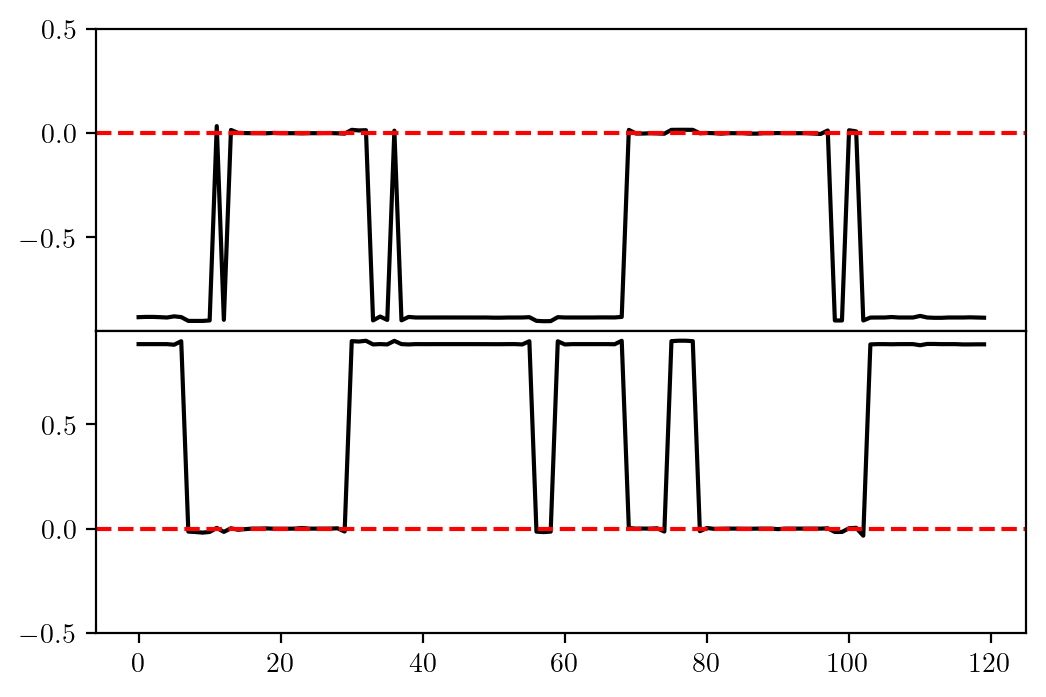

In [16]:
import matplotlib.pyplot as plt

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

fig, (ax1, ax2) = plt.subplots(2, dpi=200, sharex=True)
fig.subplots_adjust(hspace=0)





# fig.suptitle("%2.0f doped electron, $U = %5.1f t, \Gamma = %5.1f t$" % tuple((dope, U, gamma)))


#######################
ax1.plot(range(Lx), delta_n[3], color = 'k')
ax2.plot(range(Lx), delta_n[Ly-4], color = 'k')

for ax in [ax1, ax2]:
    # ax.set_ylim(-0.55,0.55)
    ax.set_yticks([-0.5, 0, 0.5])
    ax.axhline(0, linestyle='--', color = 'r')
    
    